## Установка Clickhouse-driver

In [1]:
pip install clickhouse-driver

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Wintprox.DESKTOP-FVCLB92\anaconda3\python.exe -m pip install --upgrade pip' command.


## Импорт бибилиотек

In [2]:
from clickhouse_driver import Client
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Подключение к базде данных

In [3]:
client = Client(host = "dev-01.aksimemor.me",
                port = 9000,
                database = "default",
                user = "thanos",
                password = "show_me_your_data")

Запрос в БД таблицу Marvel для просмотра первых 3 записей и преобразхование в DF будем делать за счет следующего кода

In [4]:
top3, columns = client.execute('SELECT * FROM marvel LIMIT 3', 
                                 {'species': "Iris-setosa"},
                                 with_column_types=True)
top3 = pd.DataFrame(top3, columns=[tuple[0] for tuple in columns])
top3

,user_id,installed_at,created_at,day,country,app_version_short,last_time_spent,lifetime_session_count,activity_kind,event_name,reporting_revenue
0,0cc89e46-55b4-dfb5-0095-0fb01928c395,2019-12-26 03:38:47,2020-03-27 14:40:38,92,us,1.7.4,0,12,event,revenue_all,2.99
1,0cc89e46-55b4-dfb5-0095-0fb01928c395,2019-12-26 03:38:47,2020-03-27 16:25:38,92,us,1.7.4,0,13,event,revenue_all,6.99
2,0cc89e46-55b4-dfb5-0095-0fb01928c395,2019-12-26 03:38:47,2020-03-28 01:11:46,92,us,1.7.4,0,17,event,revenue_all,6.99


In [5]:
top3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   user_id                 3 non-null      object        
 1   installed_at            3 non-null      datetime64[ns]
 2   created_at              3 non-null      datetime64[ns]
 3   day                     3 non-null      int64         
 4   country                 3 non-null      object        
 5   app_version_short       3 non-null      object        
 6   last_time_spent         3 non-null      int64         
 7   lifetime_session_count  3 non-null      int64         
 8   activity_kind           3 non-null      object        
 9   event_name              3 non-null      object        
 10  reporting_revenue       3 non-null      float64       
dtypes: datetime64[ns](2), float64(1), int64(3), object(5)
memory usage: 392.0+ bytes


## Описание данных
user_id - id игрока  
installed_at - Дата и время установки  
created_at - Дата и время события  
day - День жизни игрока с момента установки  
country - Страна пользователя в момент совершения   события
app_version_short - Версия мобильного приложения  
last_time_spent - Продолжительность последней сессии в   секундах  
lifetime_session_count - Общее кол-во сессий игрока к данному событию  
activity_kind - Тип события  
event_name - Название события  
reporting_revenue - Выручка  

## ARPU
ARPU (по дням, неделям и месяцам) - средний доход с одного активного пользователя

### Запрос в SQL: 
    SELECT     
        toYYYYMM(installed_at) as dateIn, 
        toYYYYMM(created_at) as dateCr,   
        dateDiff(month, installed_at, created_at) as Month,  
        COUNT(DISTINCT(user_id)) as ordersCount,   
        SUM(reporting_revenue) as sumRev,   
        (SUM(reporting_revenue)/COUNT(DISTINCT(user_id))) as ARPUMonth    
    FROM marvel   
    GROUP BY dateIn, dateCr, Month
    
Для недельных и ежедневных данных заменим dateDiff на нужные когорты

## ARPU Month

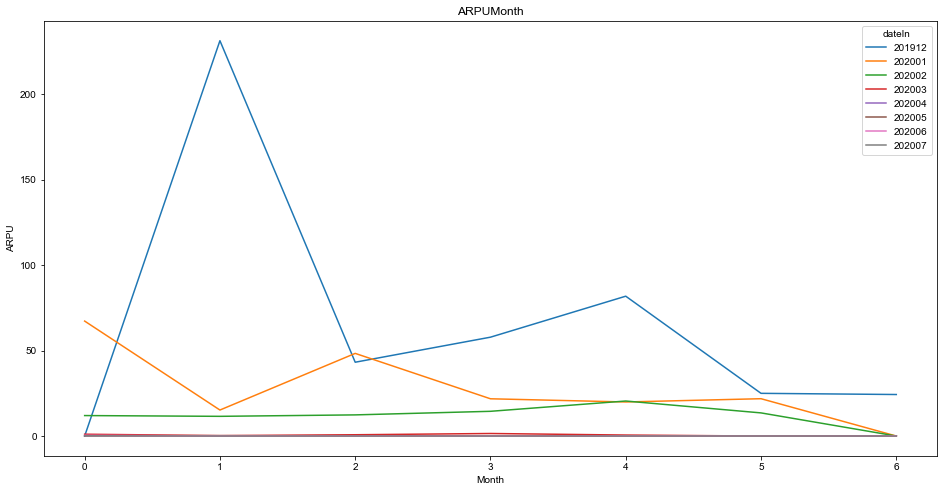

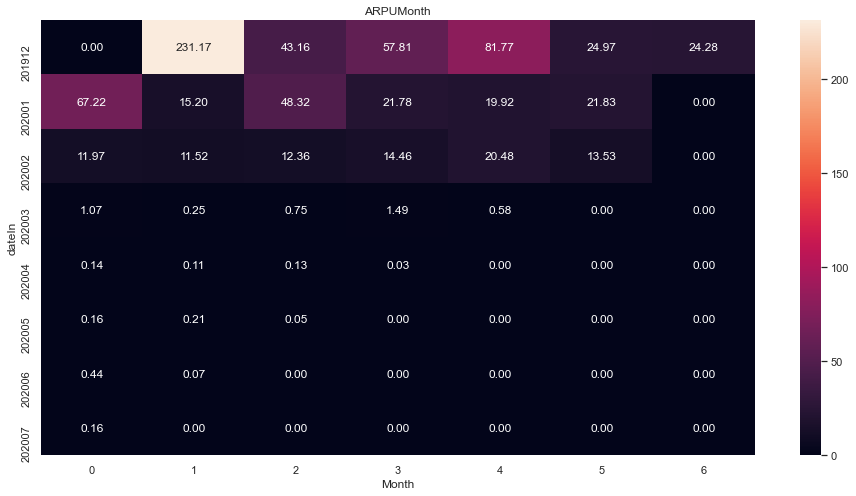

In [6]:
ARPUmonth, columns = client.execute('SELECT toYYYYMM(installed_at) as dateIn, toYYYYMM(created_at) as dateCr, dateDiff(month, installed_at, created_at) as Month, COUNT(DISTINCT(user_id)) as ordersCount, SUM(reporting_revenue) as sumRev, (SUM(reporting_revenue)/COUNT(DISTINCT(user_id))) as ARPUMonth  FROM marvel GROUP BY dateIn, dateCr, Month',
                                 {'species': "Iris-setosa"},
                                 with_column_types=True)
ARPUmonth = pd.DataFrame(ARPUmonth, columns=[tuple[0] for tuple in columns])
CohortARPUmonth = ARPUmonth.pivot_table(index='dateIn', columns='Month', values='ARPUMonth')
CohortARPUmonth.fillna(0, inplace=True)

#График когорт
CohortARPUmonth.T.plot(figsize=(16, 8))
plt.title('ARPUMonth')
plt.ylabel('ARPU')

#Матрица когорты
sns.set(style='white')
plt.figure(figsize=(16, 8))
plt.title('ARPUMonth')
sns.heatmap(CohortARPUmonth, annot=True, fmt='.2f')

## ARPU Week

Text(0, 0.5, 'ARPU')

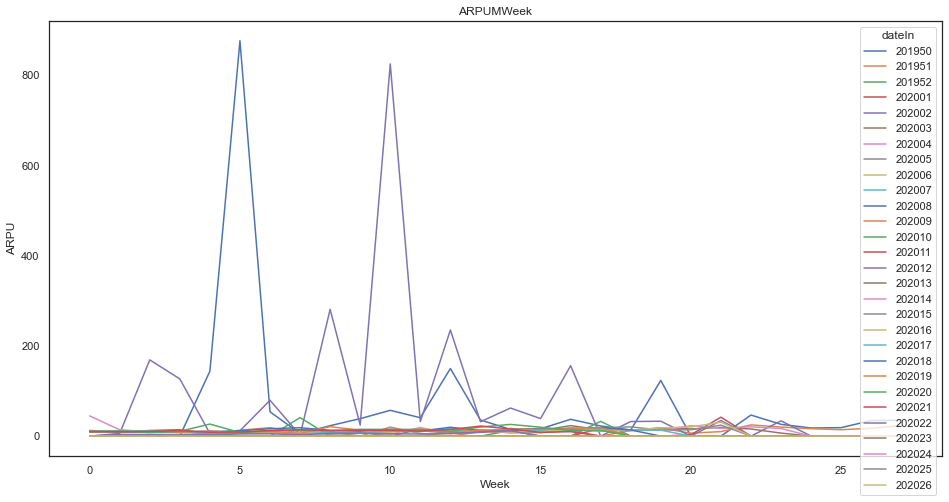

In [7]:
ARPUWeek, columns = client.execute('SELECT toYearWeek(installed_at) as dateIn, toYearWeek(created_at) as dateCr, dateDiff(week, installed_at, created_at) as Week, COUNT(DISTINCT(user_id)) as ordersCount, SUM(reporting_revenue) as sumRev, (SUM(reporting_revenue)/COUNT(DISTINCT(user_id))) as ARPUWeek FROM marvel GROUP BY dateIn, dateCr, Week',
                                 {'species': "Iris-setosa"},
                                 with_column_types=True)
ARPUweek = pd.DataFrame(ARPUWeek, columns=[tuple[0] for tuple in columns])
CohortARPUWeek = ARPUweek.pivot_table(index='dateIn', columns='Week', values='ARPUWeek')
CohortARPUWeek.fillna(0, inplace=True)

#График когорт
CohortARPUWeek.T.plot(figsize=(16, 8))
plt.title('ARPUMWeek')
plt.ylabel('ARPU')

#Матрица когорты (Большйо размер неудобно отображать!)
#sns.set(style='white')
#plt.figure(figsize=(16, 8))
#plt.title('ARPUWeek')
#sns.heatmap(CohortARPUWeek, annot=True, fmt='.2f')

## ARPU Day

Text(0, 0.5, 'ARPU')

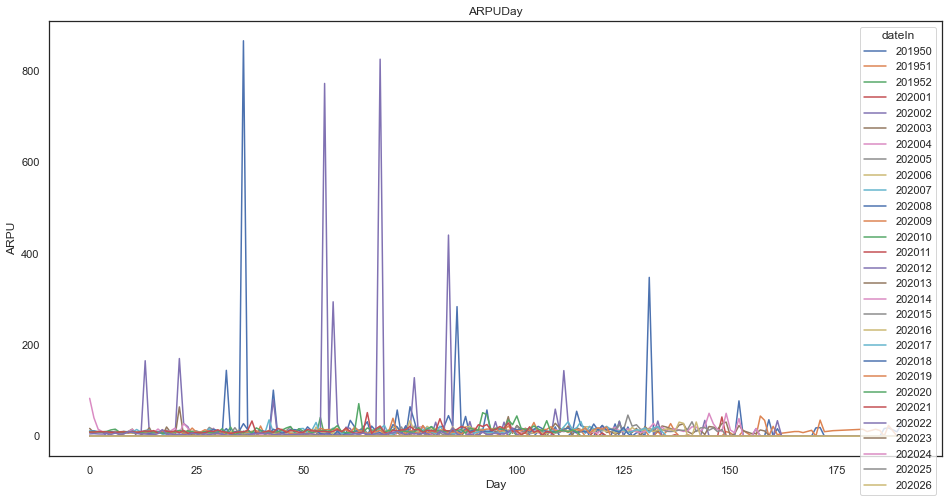

In [8]:
ARPUDay, columns = client.execute('SELECT toYearWeek(installed_at) as dateIn, toYYYYMMDD(created_at) as dateCr, dateDiff(day, installed_at, created_at) as Day, COUNT(DISTINCT(user_id)) as ordersCount, SUM(reporting_revenue) as sumRev, (SUM(reporting_revenue)/COUNT(DISTINCT(user_id))) as ARPUDay  FROM marvel GROUP BY dateIn, dateCr, Day',
                                 {'species': "Iris-setosa"},
                                 with_column_types=True)
ARPUDay = pd.DataFrame(ARPUDay, columns=[tuple[0] for tuple in columns])
CohortARPUDay = ARPUDay.pivot_table(index='dateIn', columns='Day', values='ARPUDay')
CohortARPUDay.fillna(0, inplace=True)

#График когорт (Плохо видно, так как большая выборка данных)
CohortARPUDay.T.plot(figsize=(16, 8))
plt.title('ARPUDay')
plt.ylabel('ARPU')

#Матрица когорты (Большйо размер неудобно отображать!)
#sns.set(style='white')
#plt.figure(figsize=(16, 8))
#plt.title('ARPUDay')
#sns.heatmap(CohortARPUDay, annot=True, fmt='.2f')

## Небольшие итоги по ARPU:
Для некоторых когорт имеются выбросы, большей частью это первые когорты пользователи которые зарегестрирвоались. Причины скачков могут быть различными:  
случайность,  
праздники,  
киты (игроки которые тратят больше всего денег).

## Retention
Retention - это коэффициент удержания пользователей, показывающий «возвращаемость» клиентов в приложение за определенный период после установки.

### Запрос в SQL: 
    
    SELECT 
        T1.cohort_month, 
        T1.month_number, 
        T1.num_users, 
        T2.num_users, 
        T1.num_users/T2.num_users as retention 
    FROM 
         (SELECT 
         toYYYYMM(installed_at) as cohort_month,
         dateDiff(month, installed_at, created_at) as month_number,
         count(cohort_month) as num_users 
         FROM marvel 
         group by cohort_month, month_number) AS T1,
         (SELECT toYYYYMM(installed_at) as cohort_month, 
         count(cohort_month) as num_users 
         FROM marvel 
         GROUP BY cohort_month) AS T2 
    WHERE T1.cohort_month=T2.cohort_month ORDER BY T1.cohort_month'
    
Для недельных и ежедневных данных заменим dateDiff на нужные когорты

## Retention Month

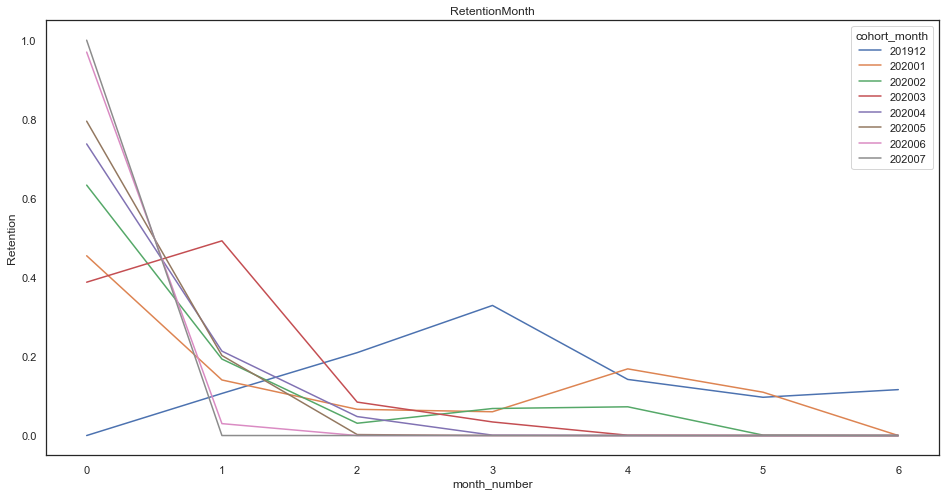

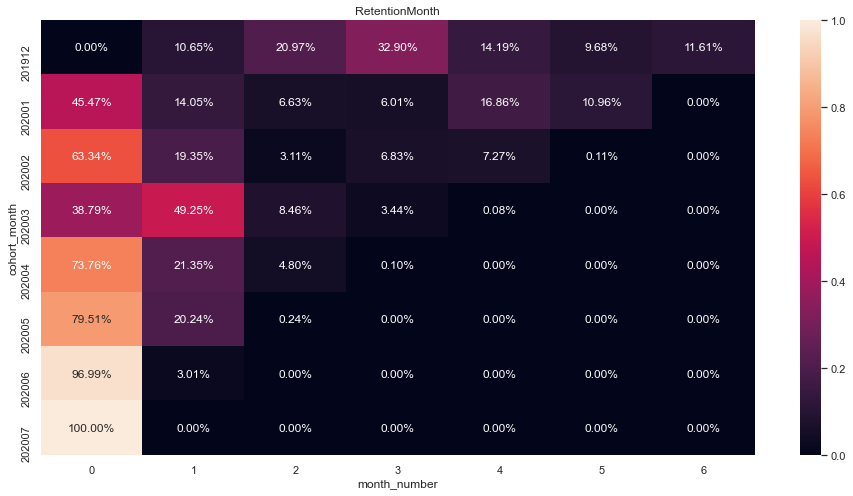

In [9]:
RetentionMonth, columns = client.execute('SELECT T1.cohort_month, T1.month_number, T1.num_users, T2.num_users, T1.num_users/T2.num_users as retention FROM (SELECT toYYYYMM(installed_at) as cohort_month, dateDiff(month, installed_at, created_at) as month_number, count(cohort_month) as num_users FROM marvel group by cohort_month, month_number) as T1, (SELECT toYYYYMM(installed_at) as cohort_month, count(cohort_month) as num_users FROM marvel group by cohort_month) as T2 WHERE T1.cohort_month=T2.cohort_month ORDER BY T1.cohort_month',
                                 with_column_types=True)
RetentionMonth = pd.DataFrame(RetentionMonth, columns=[tuple[0] for tuple in columns])
CohortRetentionMonth = RetentionMonth.pivot_table(index='cohort_month', columns='month_number', values='retention')
CohortRetentionMonth.fillna(0, inplace=True)


#График когорт (Плохо видно, так как большая выборка данных)
CohortRetentionMonth.T.plot(figsize=(16, 8))
plt.title('RetentionMonth')
plt.ylabel('Retention')

#Матрица когорты (Большйо размер неудобно отображать!)
sns.set(style='white')
plt.figure(figsize=(16, 8))
plt.title('RetentionMonth')
sns.heatmap(CohortRetentionMonth, annot=True, fmt='.2%')

## Retention Week

Text(0, 0.5, 'Retention')

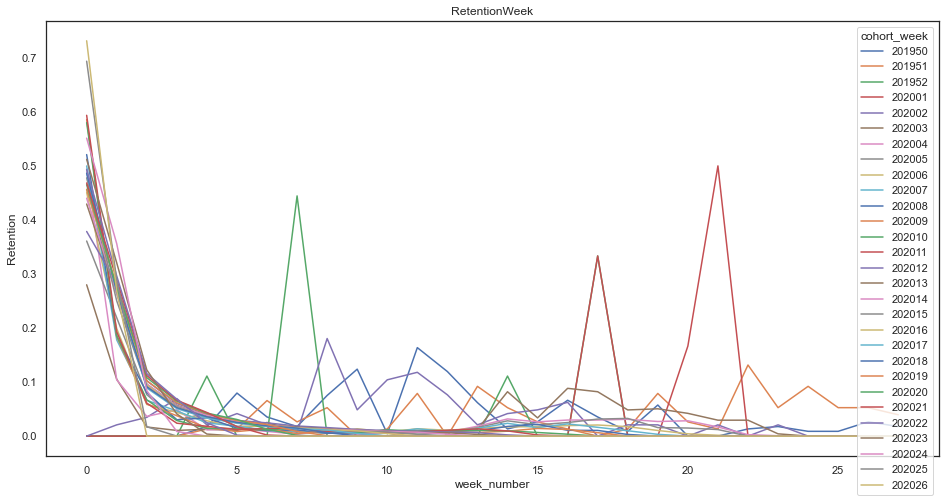

In [10]:
RetentionWeek, columns = client.execute('SELECT T1.cohort_week, T1.week_number, T1.num_users, T2.num_users, T1.num_users/T2.num_users as retention FROM (SELECT toYearWeek(installed_at) as cohort_week, dateDiff(week, installed_at, created_at) as week_number, count(cohort_week) as num_users FROM marvel group by cohort_week, week_number) as T1, (SELECT toYearWeek(installed_at) as cohort_week, count(cohort_week) as num_users FROM marvel group by cohort_week) as T2 WHERE T1.cohort_week=T2.cohort_week ORDER BY T1.cohort_week',
                                 with_column_types=True)
RetentionWeek = pd.DataFrame(RetentionWeek, columns=[tuple[0] for tuple in columns])
CohortRetentionWeek = RetentionWeek.pivot_table(index='cohort_week', columns='week_number', values='retention')
CohortRetentionWeek.fillna(0, inplace=True)


#График когорт (Плохо видно, так как большая выборка данных)
CohortRetentionWeek.T.plot(figsize=(16, 8))
plt.title('RetentionWeek')
plt.ylabel('Retention')

#Матрица когорты (Большой размер неудобно отображать!)
#sns.set(style='white')
#plt.figure(figsize=(16, 8))
#plt.title('RetentionMonth')
#sns.heatmap(CohortRetentionWeek, annot=True, fmt='.2%')

## Retention Day

Text(0, 0.5, 'Retention')

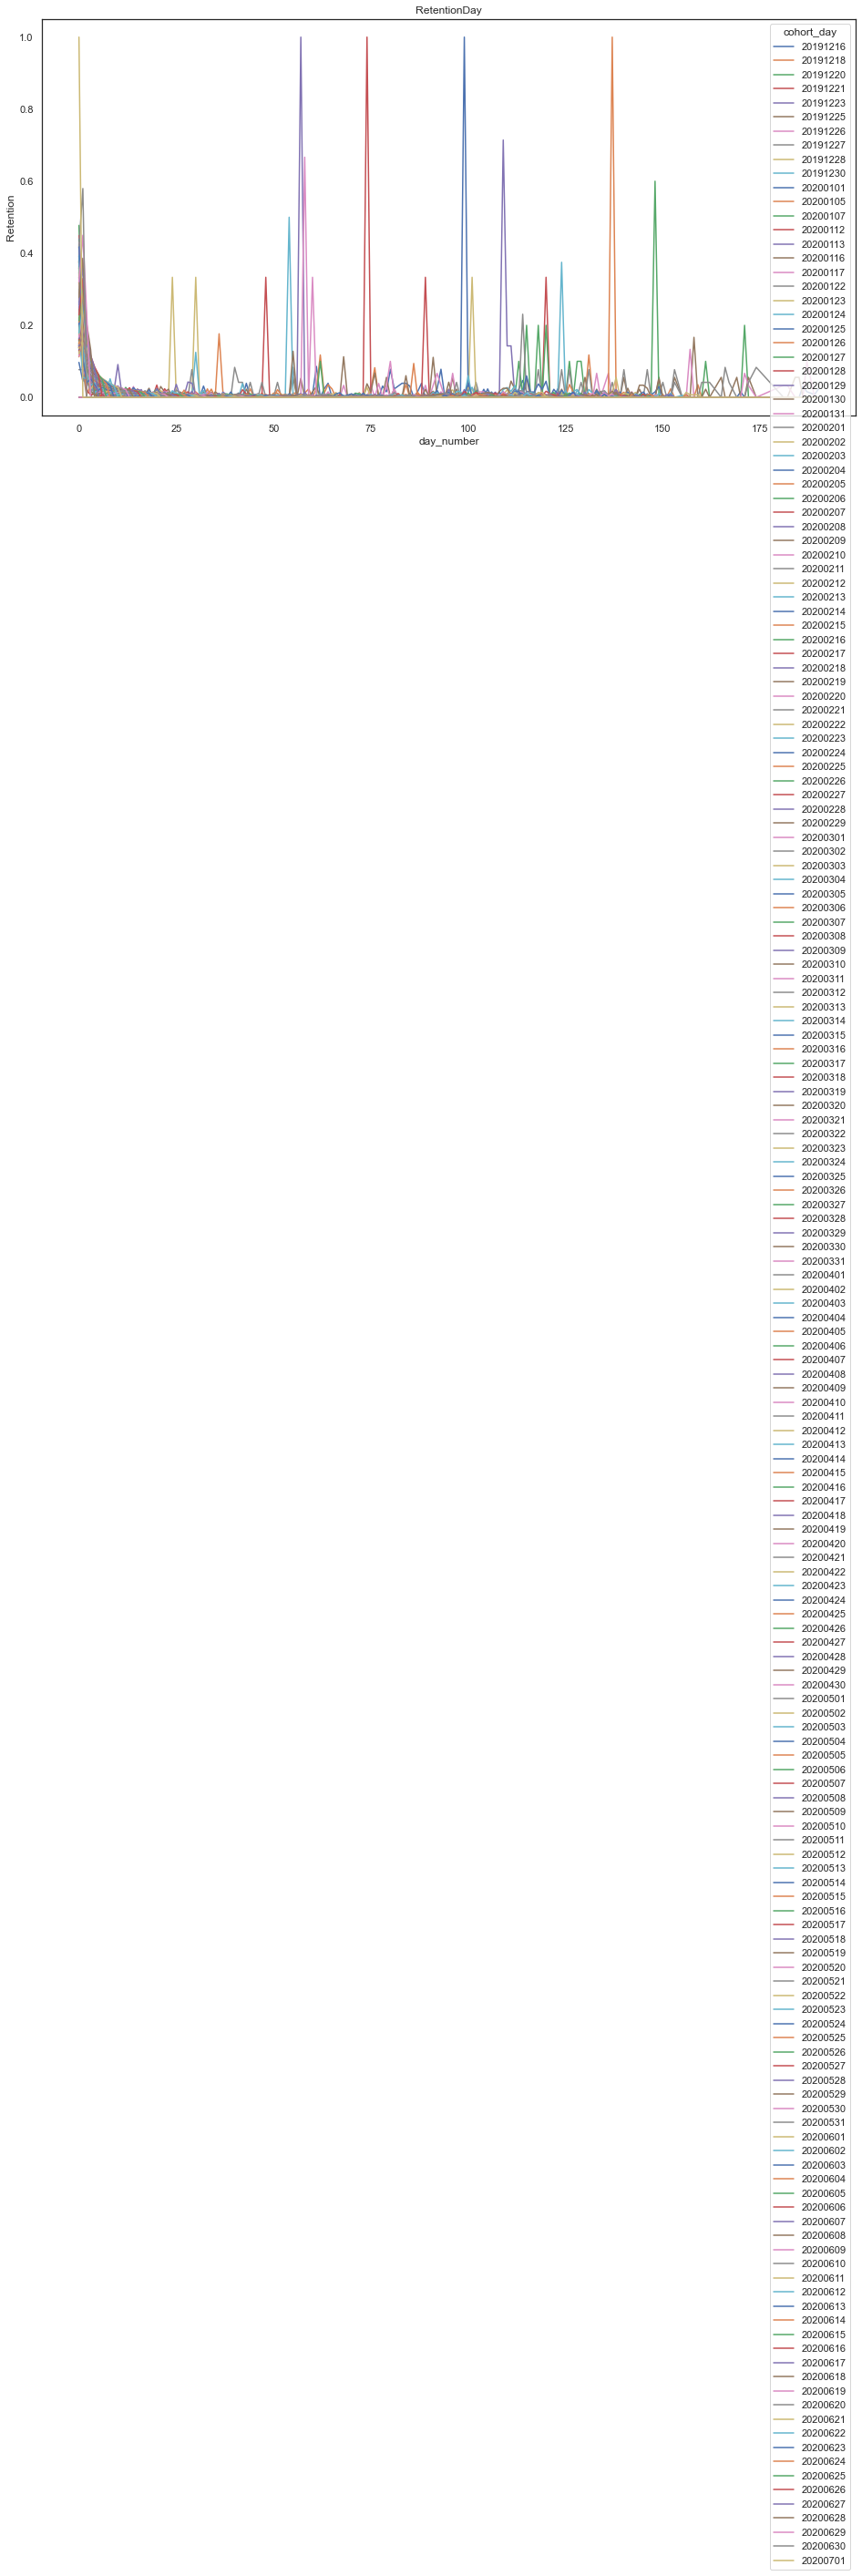

In [11]:
RetentionDay, columns = client.execute('SELECT T1.cohort_day, T1.day_number, T1.num_users, T2.num_users, T1.num_users/T2.num_users as retention FROM (SELECT toYYYYMMDD(installed_at) as cohort_day, dateDiff(day, installed_at, created_at) as day_number, count(cohort_day) as num_users FROM marvel group by cohort_day, day_number) as T1, (SELECT toYYYYMMDD(installed_at) as cohort_day, count(cohort_day) as num_users FROM marvel group by cohort_day) as T2 WHERE T1.cohort_day=T2.cohort_day ORDER BY T1.cohort_day',
                                 with_column_types=True)
RetentionDay = pd.DataFrame(RetentionDay, columns=[tuple[0] for tuple in columns])
CohortRetentionDay = RetentionDay.pivot_table(index='cohort_day', columns='day_number', values='retention')
CohortRetentionDay.fillna(0, inplace=True)


#График когорт (Плохо видно, так как большая выборка данных)
CohortRetentionDay.T.plot(figsize=(16, 8))
plt.title('RetentionDay')
plt.ylabel('Retention')

#Матрица когорты (Большой размер неудобно отображать!)
#sns.set(style='white')
#plt.figure(figsize=(16, 8))
#plt.title('RetentionMonth')
#sns.heatmap(CohortRetentionDay, annot=True, fmt='.2%')

## Небольшие итоги по Retention:
Для некоторых когорт имеются выбросы. Причины скачков могут быть различными, но я думаю причина в ивентах.